In [1]:
import numpy as np
from scipy.sparse.linalg import svds
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from scipy.linalg import lu

In [2]:
def check_spanrd(vectors, d):
    """
    Inputs:
        - vectors (array): matrix (N, d)
        - d (int): dimension of the space to be spanned
    Return:
        - True or False
    """
    # https://math.stackexchange.com/questions/56201/how-to-tell-if-a-set-of-vectors-spans-a-space
    # https://stackoverflow.com/questions/15638650/is-there-a-standard-solution-for-gauss-elimination-in-python
    pl, u = lu(vectors, permute_l=True)
    rank = np.linalg.matrix_rank(u)
    return d == int(rank)

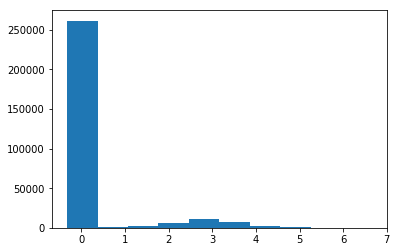

Loaded dataset: (1322, 220)
ratings: max 6.648947490095273 - min -0.3259578617346158


In [4]:
# load data

data_path = "lastfmlog.npy"

ratings = np.load(data_path)
#print(np.mean(ratings), np.sum(ratings > 0), ratings.size)
ratings = (ratings - np.mean(ratings)) / np.std(ratings)

import matplotlib.pyplot as plt
plt.hist(ratings.flatten())
plt.show()

print("Loaded dataset: {}".format(ratings.shape))

n_users, n_items = ratings.shape
print("ratings: max {0} - min {1}".format(ratings.max(), ratings.min()))

In [5]:
# SVD

K = 150
U, s, Vt = svds(ratings, k=K)
s = np.diag(s)
U = np.dot(U, s)

# MSE
Yhat = U.dot(Vt)
rmse = np.sqrt(np.mean(np.abs(Yhat - ratings) ** 2))
print("K: ", K)
print("RMSE:", rmse)
print("MAX_ERR:", np.abs(Yhat - ratings).max())

K:  150
RMSE: 0.2765351286203227
MAX_ERR: 2.876380863604467


In [6]:
def save_model(net, normalize=False):

    # Build features
    X_pred = X

    hidden_layer_sizes = list(net.hidden_layer_sizes)

    layer_units = [X_pred.shape[1]] + hidden_layer_sizes + [1]
    activations = [X_pred]
    for i in range(net.n_layers_ - 1):
        activations.append(np.empty((X_pred.shape[0], layer_units[i + 1])))

    net._forward_pass(activations)
    y_pred = activations[-1]
    print("MSE (original):", np.mean((y_pred.flatten() - y) ** 2))

    # get weights
    last_w = net.coefs_[-1]
    bias = np.array(net.intercepts_[-1]).reshape((1, 1))
    last_w = np.concatenate([last_w, bias])

    # get last-layer features
    last_feat = np.array(activations[-2], dtype=np.float32)
    last_feat = np.concatenate([last_feat, np.ones((X_pred.shape[0], 1))], axis=1)

    # get prediction
    pred = last_feat.dot(last_w)
    print("MSE (recomputed with last layer only):", np.mean((pred.flatten() - y) ** 2))

    # get feature matrix
    d = hidden_layer_sizes[-1] + 1
    print("d={0}".format(d))
    phi = np.empty((n_users, n_items, d), dtype=np.float32)
    idx = 0
    for t in range(n_users):
        for z in range(n_items):
            phi[t, z, :] = last_feat[idx, :] / (np.linalg.norm(last_feat[idx, :]) if normalize else 1)
            idx += 1
    assert idx == last_feat.shape[0]

    # get param
    theta = np.array(last_w, dtype=np.float32).squeeze()
    if normalize:
        theta = theta / np.linalg.norm(theta)
        
    phi_norm = round(np.linalg.norm(phi, axis=2).max(), 2)
    print("phi max norm:", phi_norm)
    theta_norm = round(np.linalg.norm(theta), 2)
    print("theta norm:", theta_norm)

    # check predictions
    mu = phi.dot(theta)
    print("MSE (mu):", np.mean(np.abs(ratings - mu).flatten()**2))
    print("mu: max {0} - min {1}".format(mu.max(), mu.min()))
    gap = np.max(mu, axis=1)[:, np.newaxis] - mu
    print("gap max:", gap.max())
    gap[gap == 0] = 100
    print("gap min:", gap.min())
    gap = np.min(gap, axis=1)
    print("# contexts with gap_min > 0.001:", np.sum(gap > 0.001))
    print("# contexts with gap_min > 0.01:", np.sum(gap > 0.01))
    print("# contexts with gap_min > 0.1:", np.sum(gap > 0.1))

    # check span
    astar = np.argmax(mu, axis=1)
    fstar = np.array([phi[x, astar[x]] for x in range(n_users)])

    span = d
    for i in range(d):
        if check_spanrd(fstar, d - i):
            span = d - i
            break

    print("{0}Spanning R^{1}".format("WARNING: " if span == d else "", span))
    
    # compute lambda HLS
    
    outer = np.matmul(fstar.T, fstar) / n_users
    lambda_hls = np.linalg.eigvals(outer).min()
    print("lambda HLS:", lambda_hls)

    # save
#     np.savez_compressed('lastfm_d{0}_span{1}_L{2:.2f}_S{3:.2f}_hls{4:.5f}.npz'.format(d,span,phi_norm,theta_norm, lambda_hls), 
#                         features=phi, theta=theta)
    np.savez_compressed('lastfm_d{0}_span{1}.npz'.format(d,span), features=phi, theta=theta)
    
    return mu

In [7]:
# generate datasets

X, y = [], []
for t in range(n_users):
    for z in range(n_items):
        feat = np.concatenate([U[t], Vt[:, z]]).ravel()
        X.append(feat)
        y.append(ratings[t, z])
X = np.array(X)
X = (X - np.mean(X, axis=0, keepdims=True)) / np.std(X, axis=0, keepdims=True)
y = np.array(y)

In [8]:
# fit networks

hidden = [256, 256]
ds = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
test_size=0.25

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

for j in ds:
    size = hidden + [j]
    print("Training NN -- Size {0}".format(size))
    net = MLPRegressor(hidden_layer_sizes=size, max_iter=500, verbose=True).fit(X_train, y_train)
    print("R^2 (size {0}): {1}".format(j, net.score(X_test, y_test)))
    print()
    print("Saving model...")
    save_model(net)
    del(net)
    print()

Training NN -- Size [256, 256, 5]
Iteration 1, loss = 0.45689128
Iteration 2, loss = 0.38335265
Iteration 3, loss = 0.34842782
Iteration 4, loss = 0.32881936
Iteration 5, loss = 0.31504306
Iteration 6, loss = 0.30293415
Iteration 7, loss = 0.29500647
Iteration 8, loss = 0.28910277
Iteration 9, loss = 0.28543216
Iteration 10, loss = 0.28012562
Iteration 11, loss = 0.27489630
Iteration 12, loss = 0.26910817
Iteration 13, loss = 0.26474857
Iteration 14, loss = 0.26150227
Iteration 15, loss = 0.25755512
Iteration 16, loss = 0.25324819
Iteration 17, loss = 0.24799641
Iteration 18, loss = 0.24380131
Iteration 19, loss = 0.24290905
Iteration 20, loss = 0.24271822
Iteration 21, loss = 0.24157589
Iteration 22, loss = 0.24229899
Iteration 23, loss = 0.24050313
Iteration 24, loss = 0.23929988
Iteration 25, loss = 0.23883341
Iteration 26, loss = 0.23722694
Iteration 27, loss = 0.23421742
Iteration 28, loss = 0.23102474
Iteration 29, loss = 0.22870129
Iteration 30, loss = 0.22650166
Iteration 31, l

Iteration 18, loss = 0.02405765
Iteration 19, loss = 0.02527018
Iteration 20, loss = 0.02300648
Iteration 21, loss = 0.02253428
Iteration 22, loss = 0.02313137
Iteration 23, loss = 0.02206967
Iteration 24, loss = 0.02101728
Iteration 25, loss = 0.02040775
Iteration 26, loss = 0.02341354
Iteration 27, loss = 0.02080733
Iteration 28, loss = 0.02014992
Iteration 29, loss = 0.01763650
Iteration 30, loss = 0.01778642
Iteration 31, loss = 0.01646153
Iteration 32, loss = 0.01743751
Iteration 33, loss = 0.01680756
Iteration 34, loss = 0.01524102
Iteration 35, loss = 0.01529493
Iteration 36, loss = 0.01655751
Iteration 37, loss = 0.01419050
Iteration 38, loss = 0.01468021
Iteration 39, loss = 0.01445894
Iteration 40, loss = 0.01423914
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
R^2 (size 25): 0.8235541553622471

Saving model...
MSE (original): 0.06496310176660305
MSE (recomputed with last layer only): 0.06496310168878285
d=26
phi max norm: 128.47
t


Training NN -- Size [256, 256, 50]
Iteration 1, loss = 0.38773072
Iteration 2, loss = 0.23882627
Iteration 3, loss = 0.14923637
Iteration 4, loss = 0.10104521
Iteration 5, loss = 0.07385585
Iteration 6, loss = 0.06094225
Iteration 7, loss = 0.05194645
Iteration 8, loss = 0.04586140
Iteration 9, loss = 0.04065352
Iteration 10, loss = 0.03968504
Iteration 11, loss = 0.03607915
Iteration 12, loss = 0.03334798
Iteration 13, loss = 0.03318276
Iteration 14, loss = 0.02916370
Iteration 15, loss = 0.02771345
Iteration 16, loss = 0.02649797
Iteration 17, loss = 0.02579277
Iteration 18, loss = 0.02649893
Iteration 19, loss = 0.02331741
Iteration 20, loss = 0.02212807
Iteration 21, loss = 0.02266475
Iteration 22, loss = 0.02143217
Iteration 23, loss = 0.02157554
Iteration 24, loss = 0.01946696
Iteration 25, loss = 0.02072789
Iteration 26, loss = 0.01823458
Iteration 27, loss = 0.01857059
Iteration 28, loss = 0.01737206
Iteration 29, loss = 0.01763318
Iteration 30, loss = 0.01838678
Iteration 31,